image has 133 rows and 200 columns


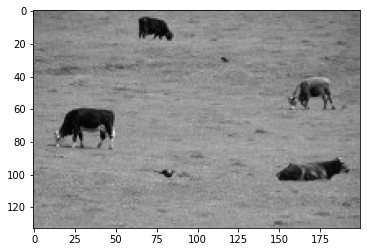

In [23]:
import numpy as np
import cv2 as cv
import math
from matplotlib import pyplot as plt

# Wir laden uns gegen Ende nochmal das gleiche Bild, daher als Variable
img_path = 'img/cows.jpg'

def read_grayscale_img(base_img_path):
    # Lena Graustufenbild einlesen
    img_grayscale = cv.imread(base_img_path, cv.IMREAD_GRAYSCALE)
    
    # Zeilen und Spalten als Variablen für folgende Zellen festhalten
    rows = len(img_grayscale);
    cols = len(img_grayscale[0]);
    return img_grayscale, rows, cols

img, rows, cols = read_grayscale_img(img_path)
print("image has", rows, "rows and", cols, "columns")
plt.imshow(img, cmap='gray')


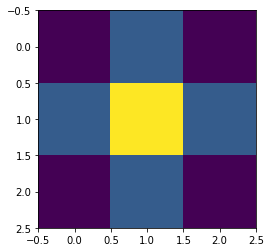

In [24]:
def create_2d_gaussian_filter(sigma, size):
    if size % 2 == 0:
        raise ValueError("size not odd: " + str(size))

    kernel = np.zeros((size,size))

    # Konstant, berechnen wir also im Vorfeld der Schleife
    base = 1 / (2 * math.pi * math.pow(sigma,2))

    # Wir benötigen die Summe aller Zellen des Kernels für eine nachträgliche Normalisierung
    total = 0

    # Index des Kernel-Zentrums
    center = (size-1)/2
    for row in range(size):
        for col in range(size):
            x = col - center
            y = row - center

            denominator = - (math.pow(x,2) + math.pow(y,2))
            nominator = 2 * math.pow(sigma, 2)
            exp = math.exp(denominator / nominator)

            kernel[row][col] = base * exp
            total += kernel[row][col]

    # jetzt muss der Kernel noch normalisiert werden
    for row in range(size):
        for col in range(size):
            kernel[row][col] /= total

    return kernel

# Beispielvisualisierung eines 2D-Gauss-Filters
plt.imshow(create_2d_gaussian_filter(
    sigma=0.75, 
    size=3))

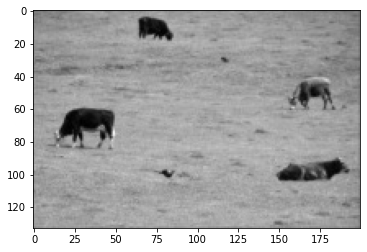

In [25]:

# Dient dem Unterstützen von Padding bei der Abfrage von Farbwerten
def get_image_pixel(base_img, rows, cols, row, col, zero_padding):
    effective_col = max(0, min(cols-1, col))
    effective_row = max(0, min(rows-1, row))
    if not zero_padding and (row < 0 or row >= rows or cols < 0 or col >= cols):
        return 0 # Zero Padding (sobel)
    return base_img[effective_row][effective_col] # Randpixelwert (gaussian blur)

# Anwendung eines 3x3 Filters um einen konkreten Pixel herum als Funktion ausgelagert
def get_filtered_value(base_img, rows, cols, filter, row, col, zero_padding):
   return filter[0][0] * get_image_pixel(base_img, rows, cols, row-1, col-1, zero_padding)  \
        + filter[0][1] * get_image_pixel(base_img, rows, cols, row-1, col, zero_padding) \
        + filter[0][2] * get_image_pixel(base_img, rows, cols, row-1, col+1, zero_padding) \
        + filter[1][0] * get_image_pixel(base_img, rows, cols, row, col-1, zero_padding) \
        + filter[1][1] * get_image_pixel(base_img, rows, cols, row, col, zero_padding) \
        + filter[1][2] * get_image_pixel(base_img, rows, cols, row, col+1, zero_padding) \
        + filter[2][0] * get_image_pixel(base_img, rows, cols, row+1, col-1, zero_padding) \
        + filter[2][1] * get_image_pixel(base_img, rows, cols, row+1, col, zero_padding) \
        + filter[2][2] * get_image_pixel(base_img, rows, cols, row+1, col+1, zero_padding)
    
# wir könnten auch einfach cv.GaussianBlur verwenden, aber das ist vmt nicht erwünscht
def apply_gaussian_blur(base_img, rows, cols):
    output_img = np.zeros_like(base_img)
    # Wir benutzen einen 3x3 Gaussfilter mit Sigma=0.5
    filter = create_2d_gaussian_filter(0.5, 3)
    # Sliding Window auf dem Bild bewegen
    for row in range(rows):
        for col in range(cols):
            output_img[row][col] = get_filtered_value(base_img, rows, cols, filter, row, col, False)
    return output_img 

# Blurry Graustufenbild visualisieren
plt.imshow(apply_gaussian_blur(img, rows, cols), cmap='gray')


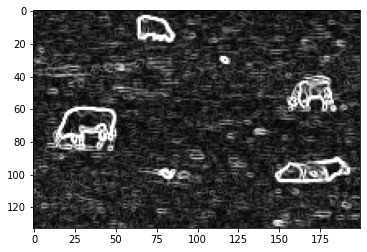

In [26]:
def apply_sobel(base_img, rows, cols):
    sobel_x = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ])
    sobel_y = np.array([
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]
    ])
    output_img = np.zeros_like(base_img)
    for row in range(rows):
        for col in range(cols):
            g_x = get_filtered_value(base_img, rows, cols, sobel_x, row, col, True)
            g_y = get_filtered_value(base_img, rows, cols, sobel_y, row, col, True)
            output_img[row][col] = min(255, math.sqrt(math.pow(g_x, 2) + math.pow(g_y, 2)))
    return output_img

# Richtungsunabhängigen Gradienten fürs Basisbild visualisieren
plt.imshow(apply_sobel(img, rows, cols), cmap='gray')



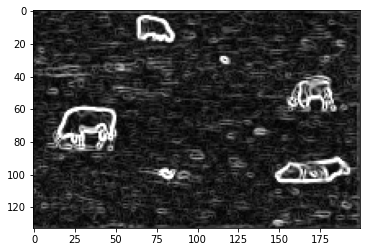

In [27]:
# Energiebild aus Basisbild berechnen
def create_energy_img(base_img, rows, cols):    
    base_img = apply_gaussian_blur(base_img, rows, cols)

    # Bild horizontal und vertikal mittels Sobel-Operator ableiten
    return apply_sobel(base_img, rows, cols)

# Energiebild fürs Basisbild visualisieren
plt.imshow(create_energy_img(img, rows, cols), cmap='gray')


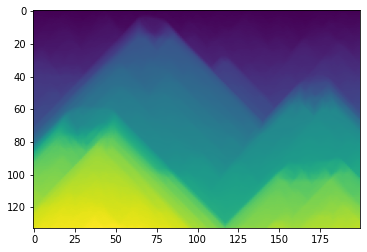

In [28]:
def init_dp(base_img, rows, cols):
    img_energy = create_energy_img(base_img, rows, cols)
    agg_values = np.zeros((rows,cols))
    pointers = np.zeros((rows,cols))

    for col in range(cols): # Initialisierung
        agg_values[0][col] = img_energy[0][col]

    return img_energy, agg_values, pointers

# Bestimmen der aggregierten Energien und resultierenden Pointer über Dyn. Programming
def perform_vertical_dp(base_img, rows, cols):
    img_energy, agg_values, pointers = init_dp(base_img, rows, cols)

    for row in range(1, rows):
        for col in range(0, cols):
            # Nachbarschaft in vorangegangener Zeile ermitteln
            top_left = 0 if col == 0 else agg_values[row-1][col-1]
            top_center = agg_values[row-1][col]
            top_right = 0 if col == cols-1 else agg_values[row-1][col+1]
            predecessors = [top_left, top_center, top_right]

            # Maximum in Konturbild setzen
            agg_values[row][col] = img_energy[row][col] + np.max(predecessors)

            # Pointer berechnen
            top_max = np.argmax(predecessors)
            pointer_col = min(cols-1,max([0, col - (top_max - 1)]))
            pointers[row][col] = pointer_col # es genügt, die Zielspalte zu merken
    # Pointers und Matrix der aggregierten Werte zurückgeben
    return pointers, agg_values

# Matrix der aggregierten Werte fürs Basisbild visualisieren
plt.imshow(perform_vertical_dp(img, rows, cols)[1])

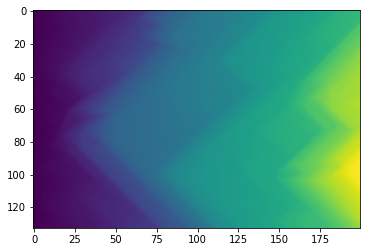

In [29]:
# Bestimmen der aggregierten Energien und resultierenden Pointer über Dyn. Programming
def perform_horizontal_dp(base_img, rows, cols):
    img_energy, agg_values, pointers = init_dp(base_img, rows, cols)

    for col in range(1, cols):
        for row in range(0, rows):
            # Nachbarschaft in vorangegangener Zeile ermitteln
            left_top = 0 if row == 0 else agg_values[row-1][col-1]
            left_center = agg_values[row][col-1]
            left_bottom = 0 if row == rows-1 else agg_values[row+1][col-1]
            predecessors = [left_top, left_center, left_bottom]

            # Maximum in Konturbild setzen
            agg_values[row][col] = img_energy[row][col] + np.max(predecessors)

            # Pointer berechnen
            left_max = np.argmax(predecessors)
            pointer_row = min(rows-1,max([0, row - (left_max - 1)]))
            pointers[row][col] = pointer_row # es genügt, die Zielzeile zu merken
    # Pointers und Matrix der aggregierten Werte zurückgeben
    return pointers, agg_values

# Matrix der aggregierten Werte fürs Basisbild visualisieren
plt.imshow(perform_horizontal_dp(img, rows, cols)[1])


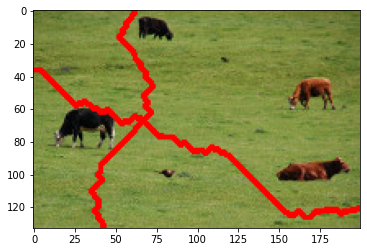

In [30]:
def find_best_vertical_seam(base_img, rows, cols):
    pointers, agg_values = perform_vertical_dp(base_img, rows, cols)
    col = np.argmax(agg_values[rows-1])
    best_seam = [col]
    for row in range(rows-1, 0, -1):
        col = int(pointers[row][col])
        best_seam.append(col)
    return best_seam

def find_best_horizontal_seam(base_img, rows, cols):
    pointers, agg_values = perform_horizontal_dp(base_img, rows, cols)
    row = np.argmax(np.array([agg_values[row][cols-1] for row in range(rows-1)]))
    best_seam = [row]
    for col in range(cols-1, 0, -1):
        row = int(pointers[row][col])
        best_seam.append(row)
    return best_seam

# zeichnet eine Kontur ausgehend von ihrer Startspalte in der letzten Bildzeile
def draw_vertical_seam(base_img, seam, rows):
    for row in range(rows-1):
        origin = seam[row]
        destination = seam[row+1]
        cv.line(base_img,(origin,rows-row-1),(destination,rows-row-2),(255,0,0),2)

# zeichnet eine Kontur ausgehend von ihrer Startzeile in der letzten Bildspalte
def draw_horizontal_seam(base_img, seam, cols):
    for col in range(cols-1):
        origin = seam[col]
        destination = seam[col+1]
        cv.line(base_img,(col,rows-origin-1),(col+1,rows-destination-1),(255,0,0),2)


best_vertical_seam = find_best_vertical_seam(img, rows, cols)
best_horizontal_seam = find_best_horizontal_seam(img, rows, cols)

img_color_with_seams = cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB)

draw_vertical_seam(img_color_with_seams, best_vertical_seam, rows)
draw_horizontal_seam(img_color_with_seams, best_horizontal_seam, cols)

plt.imshow(img_color_with_seams)

<Figure size 432x288 with 0 Axes>

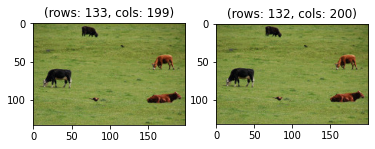

In [31]:
# entfernt eine vertikale Kontur aus einem Bild
def remove_vertical_seam_from_img(base_img, seam, rows):
    base_img_list = base_img.tolist()
    for row in range(rows):
        base_img_list[row].pop(seam[row])
    return np.array(base_img_list).astype(np.uint8)

# entfernt eine horizontale Kontur aus einem Bild
def remove_horizontal_seam_from_img(base_img, seam, cols):
    base_img_list = np.rot90(base_img).tolist()
    for col in range(cols):
        base_img_list[col].pop(seam[col])
    return np.rot90(np.array(base_img_list),3).astype(np.uint8)

plt.figure()
f, ax = plt.subplots(1,2)

img_color_without_vertical_seam = remove_vertical_seam_from_img(cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB), best_vertical_seam, rows)
ax[0].imshow(img_color_without_vertical_seam)
ax[0].title.set_text('(rows: ' + str(len(img_color_without_vertical_seam)) + ', cols: ' + str(len(img_color_without_vertical_seam[0])) + ')')

img_color_without_horizontal_seam = remove_horizontal_seam_from_img(cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB), best_horizontal_seam, cols)
ax[1].imshow(img_color_without_horizontal_seam)
ax[1].title.set_text('(rows: ' + str(len(img_color_without_horizontal_seam)) + ', cols: ' + str(len(img_color_without_horizontal_seam[0])) + ')')

removed 1 columns
removed 2 columns
removed 3 columns
removed 4 columns
removed 5 columns
removed 6 columns
removed 7 columns
removed 8 columns
removed 9 columns
removed 10 columns
removed 1 rows
removed 2 rows
removed 3 rows
removed 4 rows
removed 5 rows
removed 6 rows
removed 7 rows
removed 8 rows
removed 9 rows
removed 10 rows
removed 11 rows
removed 12 rows
removed 13 rows
removed 14 rows
removed 15 rows
removed 16 rows
removed 17 rows
removed 18 rows
removed 19 rows
removed 20 rows
removed 21 rows
removed 22 rows
removed 23 rows
removed 24 rows
removed 25 rows
removed 26 rows
removed 27 rows
removed 28 rows
removed 29 rows
removed 30 rows
removed 31 rows
removed 32 rows
removed 33 rows
removed 34 rows
removed 35 rows
removed 36 rows
removed 37 rows
removed 38 rows
removed 39 rows
removed 40 rows


<Figure size 432x288 with 0 Axes>

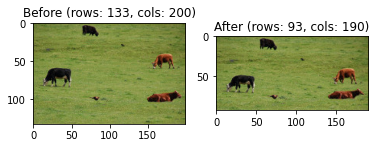

In [32]:
# Jetzt wollen wir das Seam Carving zum Ausschneiden einer beliebigen Anzahl Zeilen und Spalten verwenden
def seam_carving(img_path, remove_rows, remove_cols):

    # Im zur Verfügung gestellten Paper wird auch auf das Festlegen der Reihenfolge beim Herausschneiden von Seams eingegangen.
    # Wir werden hier "stumpf" zunächst Spalten, dann Zeilen entfernen.

    # Aus diesem Bild entfernen wir unsere ermittelten Konturen
    work_img_color = cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB)
    work_img_gray, work_img_rows, work_img_columns = read_grayscale_img(img_path)

    # Spalten entfernen
    for col in range(remove_cols):
        vertical_seam = find_best_vertical_seam(work_img_gray, work_img_rows, work_img_columns)
        work_img_gray = remove_vertical_seam_from_img(work_img_gray, vertical_seam, work_img_rows)
        work_img_color = remove_vertical_seam_from_img(work_img_color, vertical_seam, work_img_rows)
        print('removed ' + str(col + 1) + ' columns')
        work_img_columns -= 1

    # Zeilen entfernen
    for row in range(remove_rows):
        horizontal_seam = find_best_horizontal_seam(work_img_gray, work_img_rows, work_img_columns)
        work_img_gray = remove_horizontal_seam_from_img(work_img_gray, horizontal_seam, work_img_columns)
        work_img_color = remove_horizontal_seam_from_img(work_img_color, horizontal_seam, work_img_columns)
        print('removed ' + str(row + 1) + ' rows')
        work_img_rows -= 1

    return work_img_color

# Auf gehts!
after_img = seam_carving(
    img_path=img_path,
    remove_rows=40,
    remove_cols=10
)

plt.figure()
f, ax = plt.subplots(1,2)

before_img = cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB)
ax[0].imshow(before_img)
ax[0].title.set_text('Before (rows: ' + str(len(before_img)) + ', cols: ' + str(len(before_img[0])) + ')')

ax[1].imshow(after_img)
ax[1].title.set_text('After (rows: ' + str(len(after_img)) + ', cols: ' + str(len(after_img[0])) + ')')